<a href="https://colab.research.google.com/github/daniriojas/projects_22/blob/main/Bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
9/9 [==============================] - 8s 8ms/step - loss: 0.0677
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 9/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 10/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 12/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 13/100
9/9 [==============================] - 0s 8ms/st

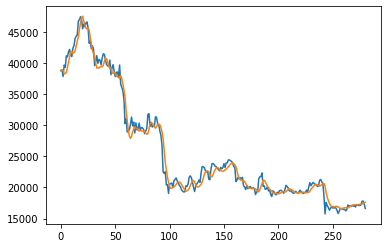

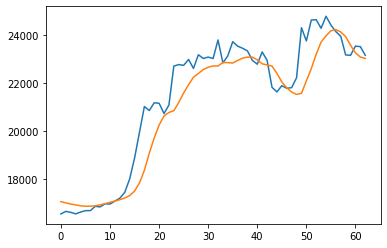

In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Define API URL and parameters for Coingecko API
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {"vs_currency": "usd", "days": "365"}

# Make API request and load data into Pandas DataFrame
response = requests.get(url, params=params)
data = pd.DataFrame(response.json()["prices"], columns=["timestamp", "Price"])

# Convert timestamp to datetime and set it as index
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="ms")
data = data.set_index("timestamp")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Define function to create time series data
def create_time_series_data(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for use in LSTM model
look_back = 10
trainX, trainY = create_time_series_data(train_data, look_back)
testX, testY = create_time_series_data(test_data, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

# Make predictions on the training and testing data
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform the predicted data back to the original scale using the scaler
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Plot the predicted and actual prices for the training data
plt.plot(trainY[0])
plt.plot(trainPredict[:,0])
plt.show()

# Plot the predicted and actual prices for the testing data
plt.plot(testY[0])
plt.plot(testPredict[:,0])
plt.show()
